In [1]:
# Data Manipulation
import os
import numpy as np
import pandas as pd

from sklearn.preprocessing import MultiLabelBinarizer
from scipy.stats import mannwhitneyu

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import missingno

sns.set(rc={"figure.figsize": (12, 3)})

## First glance

In [2]:
df = pd.read_csv(os.path.join("..", "data", "players_20.csv"))

In [3]:
df.head()

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club,...,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,32,1987-06-24,170,72,Argentina,FC Barcelona,...,68+2,66+2,66+2,66+2,68+2,63+2,52+2,52+2,52+2,63+2
1,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,34,1985-02-05,187,83,Portugal,Juventus,...,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3
2,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Junior,27,1992-02-05,175,68,Brazil,Paris Saint-Germain,...,66+3,61+3,61+3,61+3,66+3,61+3,46+3,46+3,46+3,61+3
3,200389,https://sofifa.com/player/200389/jan-oblak/20/...,J. Oblak,Jan Oblak,26,1993-01-07,188,87,Slovenia,Atlético Madrid,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,183277,https://sofifa.com/player/183277/eden-hazard/2...,E. Hazard,Eden Hazard,28,1991-01-07,175,74,Belgium,Real Madrid,...,66+3,63+3,63+3,63+3,66+3,61+3,49+3,49+3,49+3,61+3


104 features are a lot. Let's see which we are neccesary for an in-depth exploration...

---

In [4]:
drop_columns = [
    "sofifa_id",
    "player_url",
    "dob",
    "body_type",
    "work_rate",
    "loaned_from",
    "joined",
    "nation_position",
    "nation_jersey_number",
    "real_face",
]

# Drop position buffs too
drop_columns += list(df.columns[-26:])

# Drop gk_* stats as they are redundant
gk_stats = [
    "gk_diving",
    "gk_handling",
    "gk_kicking",
    "gk_reflexes",
    "gk_speed",
    "gk_positioning",
]

drop_columns += gk_stats

df.drop(drop_columns, axis=1, inplace=True)

Lets continue with the look on the data...

---

In [5]:
df.head()

,short_name,long_name,age,height_cm,weight_kg,nationality,club,overall,potential,value_eur,...,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
0,L. Messi,Lionel Andrés Messi Cuccittini,32,170,72,Argentina,FC Barcelona,94,94,95500000,...,75,96,33,37,26,6,11,15,14,8
1,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,34,187,83,Portugal,Juventus,93,93,58500000,...,85,95,28,32,24,7,11,15,14,11
2,Neymar Jr,Neymar da Silva Santos Junior,27,175,68,Brazil,Paris Saint-Germain,92,92,105500000,...,90,94,27,26,29,9,9,15,15,11
3,J. Oblak,Jan Oblak,26,188,87,Slovenia,Atlético Madrid,91,93,77500000,...,11,68,27,12,18,87,92,78,90,89
4,E. Hazard,Eden Hazard,28,175,74,Belgium,Real Madrid,91,91,90000000,...,88,91,34,27,22,11,12,6,8,8


In [6]:
df.describe()

,age,height_cm,weight_kg,overall,potential,value_eur,wage_eur,international_reputation,weak_foot,skill_moves,...,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
count,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,1.827800e+04,18278.000000,18278.000000,18278.000000,18278.000000,...,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000,18278.000000
mean,25.283291,181.362184,75.276343,66.244994,71.546887,2.484038e+06,9456.942773,1.103184,2.944250,2.368038,...,48.383357,58.528778,46.848889,47.640333,45.606631,16.572765,16.354853,16.212934,16.368038,16.709924
std,4.656964,6.756961,7.047744,6.949953,6.139669,5.585481e+06,21351.714095,0.378861,0.664656,0.765038,...,15.708099,11.880840,20.091287,21.585641,21.217734,17.738069,16.996925,16.613665,17.136497,18.038125
min,16.000000,156.000000,50.000000,48.000000,49.000000,0.000000e+00,0.000000,1.000000,1.000000,1.000000,...,7.000000,12.000000,1.000000,5.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,22.000000,177.000000,70.000000,62.000000,67.000000,3.250000e+05,1000.000000,1.000000,3.000000,2.000000,...,39.000000,51.000000,29.000000,27.000000,24.000000,8.000000,8.000000,8.000000,8.000000,8.000000
50%,25.000000,181.000000,75.000000,66.000000,71.000000,7.000000e+05,3000.000000,1.000000,3.000000,2.000000,...,49.000000,60.000000,52.000000,55.000000,52.000000,11.000000,11.000000,11.000000,11.000000,11.000000
75%,29.000000,186.000000,80.000000,71.000000,75.000000,2.100000e+06,8000.000000,1.000000,3.000000,3.000000,...,60.000000,67.000000,64.000000,66.000000,64.000000,14.000000,14.000000,14.000000,14.000000,14.000000
max,42.000000,205.000000,110.000000,94.000000,95.000000,1.055000e+08,565000.000000,5.000000,5.000000,5.000000,...,92.000000,96.000000,94.000000,92.000000,90.000000,90.000000,92.000000,93.000000,91.000000,92.000000


In [7]:
df.describe(include="O")

,short_name,long_name,nationality,club,player_positions,preferred_foot,player_tags,team_position,player_traits
count,18278,18278,18278,18278,18278,18278,1499,18038,7566
unique,17354,18218,162,698,643,2,83,29,921
top,J. Rodríguez,Liam Kelly,England,Atlético Madrid,CB,Right,#Strength,SUB,Early Crosser
freq,11,3,1667,33,2322,13960,514,7820,501


For the moment the feature selection is okay. However, we need to one-hot encode player tags and player traits later on.

### Missing Values

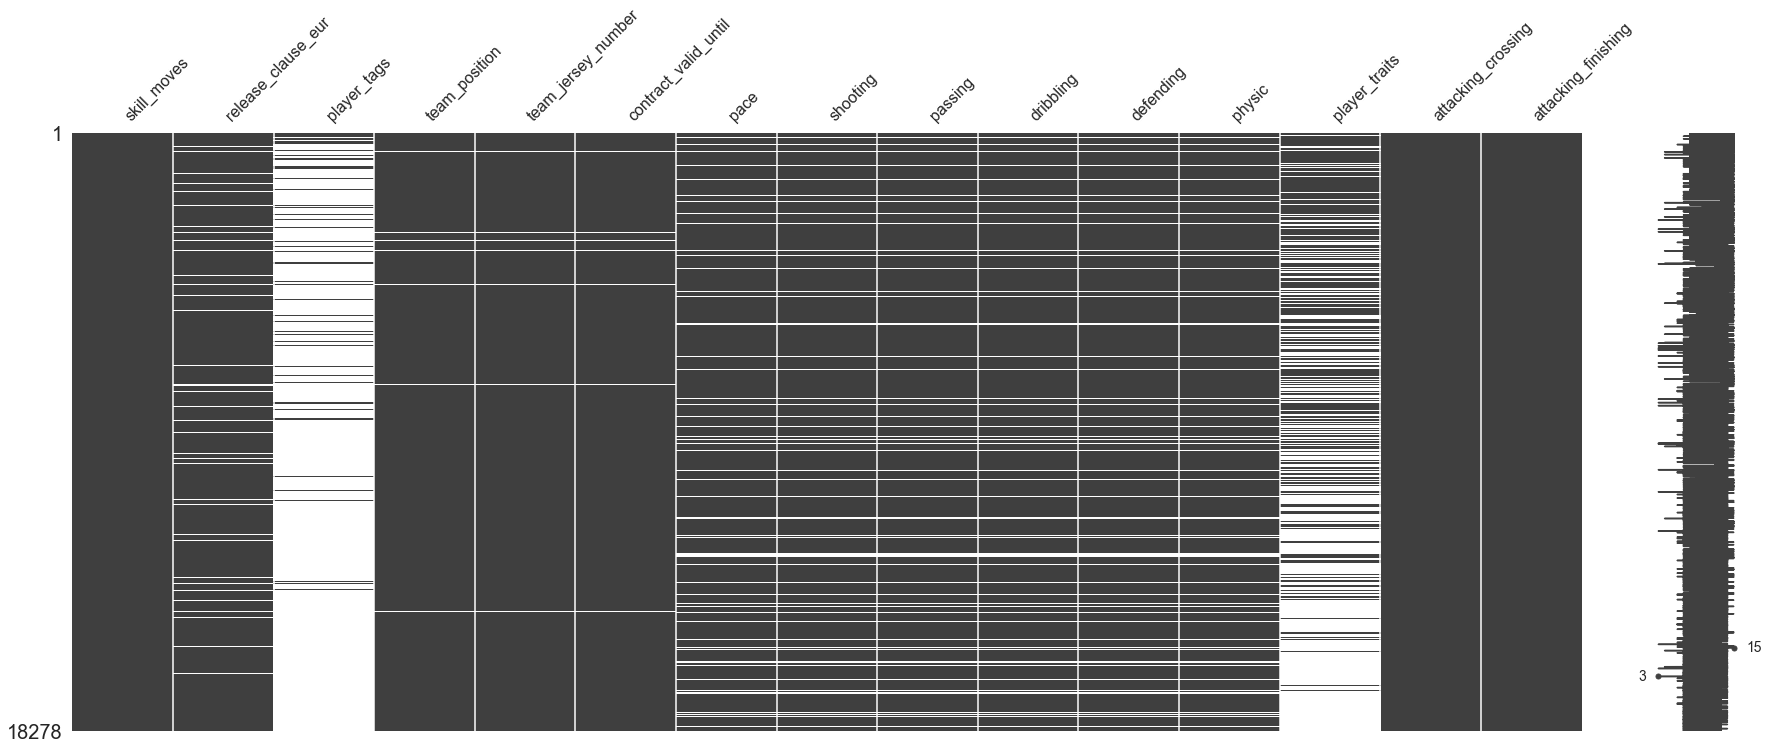

In [8]:
missingno.matrix(df.iloc[:, 15:30], figsize=(30, 11))

What needs to be looked at:
- Missing contract_valid_until -> No club
- Missing main attributes (pace, etc.)

In [9]:
# Players without a contract_valid_until feature are looking for a club (Their club equals their nationality). 
# For better understanding we will change their club to "None"

df.loc[df.contract_valid_until.isnull(), "club"] = "None"

# Also, we impute the contract_valid_until column

df.loc[df.contract_valid_until.isnull(), "contract_valid_until"] = -1

In [10]:
df[df.pace.isnull()].team_position.value_counts()

SUB    928
GK     662
RES    406
Name: team_position, dtype: int64

Main attributes are missing for goalkeepers, subs and reserve players. We will not adress this for the moment

### Outlier Detection

In [11]:
def plot_distributions(df, fig_width, fig_height, wspace, hspace, rows, cols):
    fig = plt.figure(figsize=(fig_width, fig_height))
    fig.subplots_adjust(wspace=wspace, hspace=hspace)
    
    skip_features = [
        "short_name",
        "long_name",
        "player_tags",
        "player_positions",
        "club",
        "player_traits",
        "nationality",
    ]
    
    for i, feature in enumerate(df.columns):
        if feature in skip_features:
            continue
            
        ax = fig.add_subplot(rows, cols, i+1)
        ax.set_title(feature)
        
        if df[feature].dtype == "O":
            sns.countplot(df[feature])
            plt.xticks(rotation=90)
        else:
            sns.boxplot(df[feature])
            
        plt.xlabel("")
        plt.ylabel("")

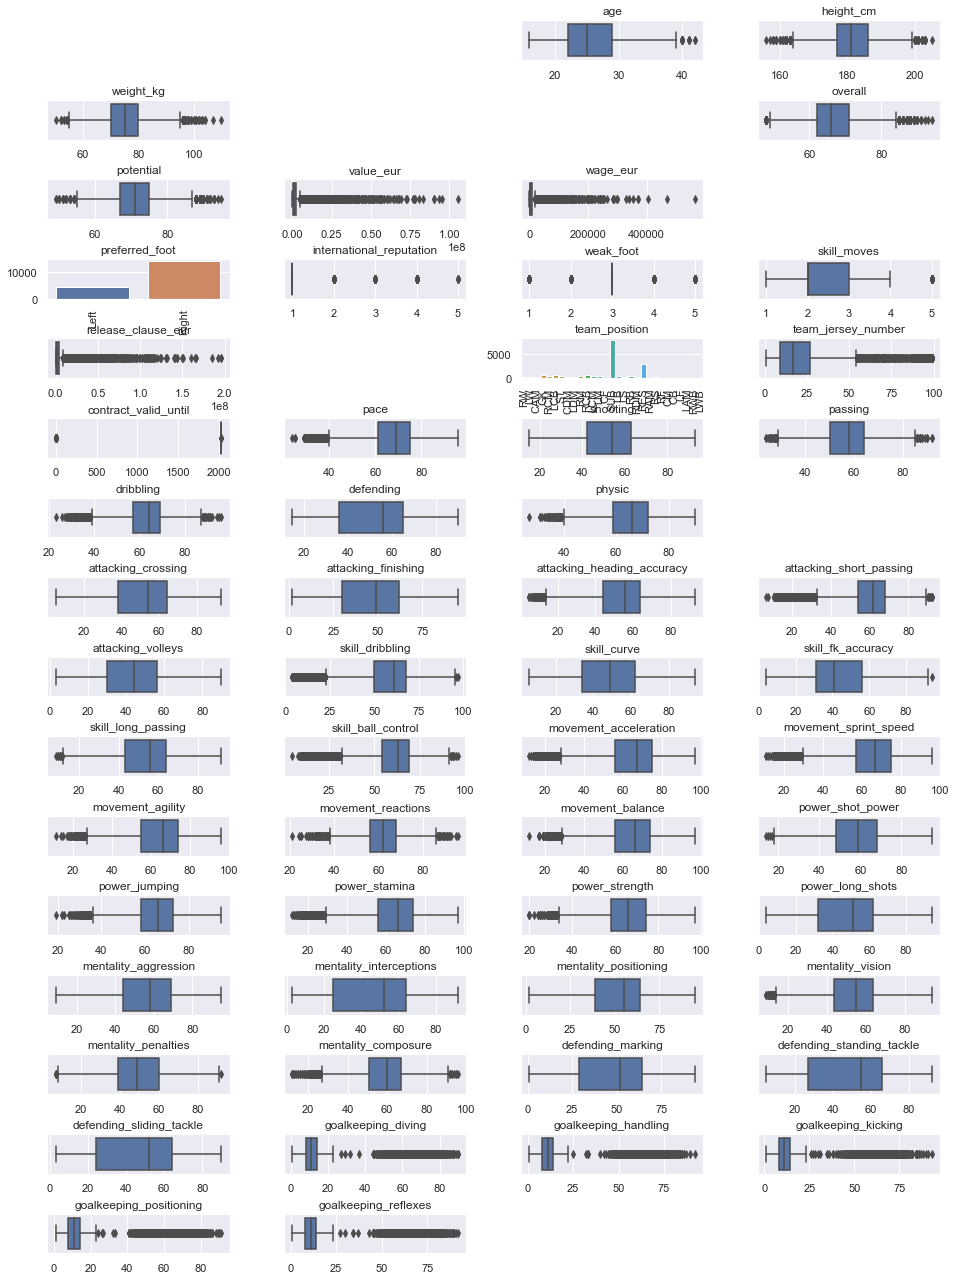

In [12]:
plot_distributions(df.iloc[:, :], 16, 30, 0.3, 1, 21, 4)

Since its a game we can omit looking for measurement errors. There are a few interesting features though:

- weight_kg shows a few outliers, it would be interesting how this effects other skills of the players
- Same thing is true for age
- Team position SUB and RES are the most common, not sure what these stand for
- The goalkeeping stats are skewed negatively by the field players
- Vice versa for other skills by the goalkeepers, however, goalkeepers are more or less rare (662 of 18278)

Inspect players without a value:

In [13]:
df[df.value_eur == 0].describe()

,age,height_cm,weight_kg,overall,potential,value_eur,wage_eur,international_reputation,weak_foot,skill_moves,...,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
count,250.000000,250.00000,250.000000,250.00000,250.000000,250.0,250.000000,250.000000,250.000000,250.000000,...,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,29.396000,181.40800,76.284000,69.06000,70.640000,0.0,236.000000,1.136000,3.040000,2.332000,...,49.316000,60.952000,48.328000,48.668000,46.708000,21.068000,20.228000,20.000000,20.520000,20.484000
std,4.481016,6.86835,6.768352,6.04139,5.999197,0.0,1885.344024,0.407638,0.663446,0.834603,...,17.405861,13.419315,22.915517,23.706492,23.555598,22.252282,21.201084,20.185883,21.754601,22.244754
min,18.000000,167.00000,60.000000,49.00000,49.000000,0.0,0.000000,1.000000,1.000000,1.000000,...,11.000000,13.000000,5.000000,7.000000,9.000000,5.000000,5.000000,5.000000,5.000000,5.000000
25%,27.000000,176.00000,71.000000,65.00000,67.000000,0.0,0.000000,1.000000,3.000000,2.000000,...,38.250000,54.000000,25.000000,25.000000,21.000000,9.000000,8.250000,9.000000,8.000000,9.000000
50%,29.000000,181.00000,76.000000,69.00000,71.000000,0.0,0.000000,1.000000,3.000000,2.000000,...,49.000000,64.000000,57.000000,58.000000,55.000000,12.000000,12.000000,12.000000,12.000000,11.000000
75%,32.000000,186.00000,81.000000,73.00000,75.000000,0.0,0.000000,1.000000,3.000000,3.000000,...,63.750000,70.000000,68.000000,69.000000,68.000000,15.000000,15.000000,15.000000,15.000000,15.000000
max,42.000000,199.00000,97.000000,82.00000,83.000000,0.0,21000.000000,3.000000,5.000000,4.000000,...,86.000000,87.000000,85.000000,85.000000,82.000000,81.000000,81.000000,81.000000,80.000000,85.000000


In [14]:
df[df.value_eur == 0].describe(include=("O"))

,short_name,long_name,nationality,club,player_positions,preferred_foot,player_tags,team_position,player_traits
count,250,250,250,250,250,250,24,10,124
unique,250,250,39,11,78,2,8,7,68
top,M. Mohsen,Andrey Semenov,India,None,GK,Right,#Strength,SUB,Avoids Using Weaker Foot
freq,1,1,23,240,40,190,10,3,7


At the moment, I don't see a reason why these players do not have a value. I will discard the players for now

In [15]:
df.drop(df[df.value_eur == 0].index, inplace=True)

In [16]:
df

,short_name,long_name,age,height_cm,weight_kg,nationality,club,overall,potential,value_eur,...,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
0,L. Messi,Lionel Andrés Messi Cuccittini,32,170,72,Argentina,FC Barcelona,94,94,95500000,...,75,96,33,37,26,6,11,15,14,8
1,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,34,187,83,Portugal,Juventus,93,93,58500000,...,85,95,28,32,24,7,11,15,14,11
2,Neymar Jr,Neymar da Silva Santos Junior,27,175,68,Brazil,Paris Saint-Germain,92,92,105500000,...,90,94,27,26,29,9,9,15,15,11
3,J. Oblak,Jan Oblak,26,188,87,Slovenia,Atlético Madrid,91,93,77500000,...,11,68,27,12,18,87,92,78,90,89
4,E. Hazard,Eden Hazard,28,175,74,Belgium,Real Madrid,91,91,90000000,...,88,91,34,27,22,11,12,6,8,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18273,Shao Shuai,邵帅,22,186,79,China PR,Beijing Renhe FC,48,56,40000,...,39,41,45,50,52,5,5,13,5,14
18274,Xiao Mingjie,Mingjie Xiao,22,177,66,China PR,Shanghai SIPG FC,48,56,40000,...,37,35,42,53,57,13,6,14,11,9
18275,Zhang Wei,张威,19,186,75,China PR,Hebei China Fortune FC,48,56,40000,...,36,39,46,52,46,7,8,10,6,14
18276,Wang Haijian,汪海健,18,185,74,China PR,Shanghai Greenland Shenhua FC,48,54,40000,...,36,40,39,44,54,14,9,13,13,13


## Multivariate analysis

### Potential Questions

- Can we predict the value of a player?
- What are the main skills for each position group (GK, Defender, Midfield, Striker)?
- How does the prefered foot affect skills//position

### Value_Eur

Description: Total value of the player in Euro

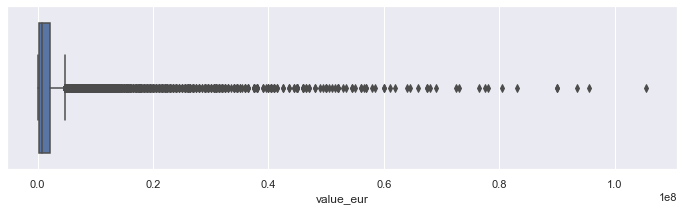

In [17]:
sns.boxplot(df.value_eur)

In [18]:
df.value_eur.describe()

count    1.802800e+04
mean     2.518485e+06
std      5.616359e+06
min      1.000000e+04
25%      3.250000e+05
50%      7.250000e+05
75%      2.100000e+06
max      1.055000e+08
Name: value_eur, dtype: float64

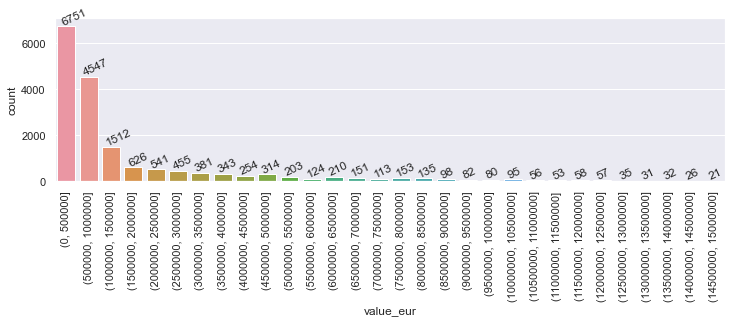

Number of players with a value > 15.000.000: 491 (2.72% of total players)


In [19]:
value_bins = pd.cut(df.value_eur, bins=np.arange(0, 15000001, 500000))

ax = sns.countplot(value_bins)
for p in ax.patches:
    ax.annotate(f"{p.get_height()}", (p.get_x()+0.1, p.get_height()+50), rotation=25)
    
plt.xticks(rotation=90)
plt.show()

print(f"Number of players with a value > 15.000.000: {len(df[df.value_eur > 15000000])} "
      f"({(100*len(df[df.value_eur > 15000000]) / len(df)):.2f}% of total players)")

We see that the distribution of player values is highly skewed. This could make it hard to predict values for high value players. 

### Age

Description: The Age of the player

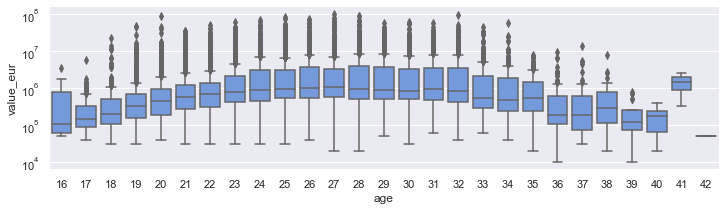

In [20]:
sns.boxplot(data=df, x="age", y="value_eur", color="CornflowerBlue")
plt.yscale("log")

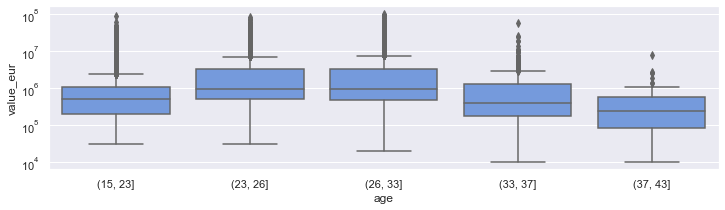

In [21]:
sns.boxplot(
    data=df,
    x=pd.cut(df.age, bins=[15, 23, 26, 33, 37, 43]),
    y="value_eur",
    color="CornflowerBlue")
plt.yscale("log")

We see that age plays a strong role in the overall value of a player. The "best age for a footballer" seems to be in the mid to late 20s to early 30s.

Whats interesting is the small value outlier of players that are 41 years old. Let's explore this...

In [22]:
df[df.age == 41]

,short_name,long_name,age,height_cm,weight_kg,nationality,club,overall,potential,value_eur,...,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
200,G. Buffon,Gianluigi Buffon,41,192,92,Italy,Juventus,83,83,2600000,...,22,70,13,11,11,78,77,74,91,80
3706,C. Lucchetti,Cristian David Lucchetti,41,182,69,Argentina,Atlético Tucumán,72,72,325000,...,54,41,21,22,13,72,69,76,70,73


We see that there are only two players in this age. This makes sense, since 41 is already quite old for any professional athlete. One of the two players is legendary goalkeeper Buffon, causing the anomaly in the boxplot comparisson.

### Overall

Description: The overall skill of the player

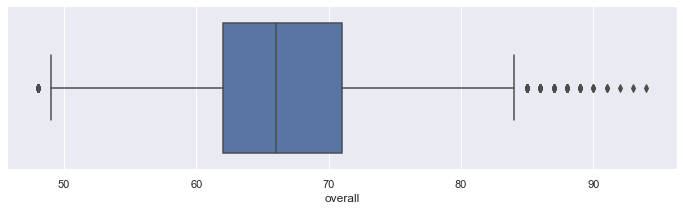

In [23]:
sns.boxplot(df.overall)

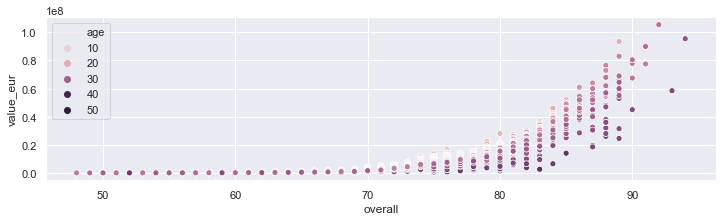

In [24]:
sns.scatterplot(data=df, x="overall", y="value_eur", hue="age")
# plt.yscale("log")

In [25]:
# Get the correlation between overall and value
df.overall.corr(other=df.value_eur)

0.6456791750668436

We see a strong linear correlation between overall skill and value. This was to be expected. Also, the outliers of very good players with rather low value are cause by older players.

### Potential

Description: The potential overall skill of the player

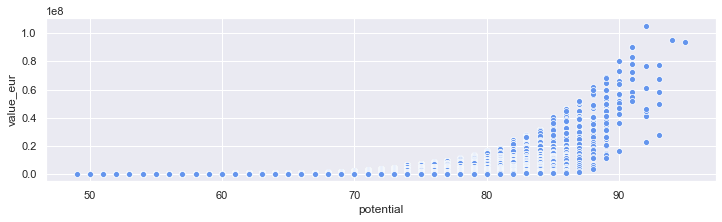

In [26]:
sns.scatterplot(data=df, x="potential", y="value_eur", color="CornflowerBlue")

The potential is equally important to the value as the overall skill. However, there might be "sleeper" players which have a high potential but are comparable cheap.

### Wage

Description: The weekly wage of the player

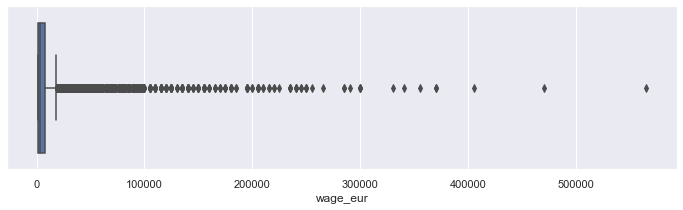

In [27]:
sns.boxplot(df.wage_eur)

In [28]:
df.wage_eur.describe()

count     18028.000000
mean       9584.812514
std       21470.293479
min        1000.000000
25%        1000.000000
50%        3000.000000
75%        8000.000000
max      565000.000000
Name: wage_eur, dtype: float64

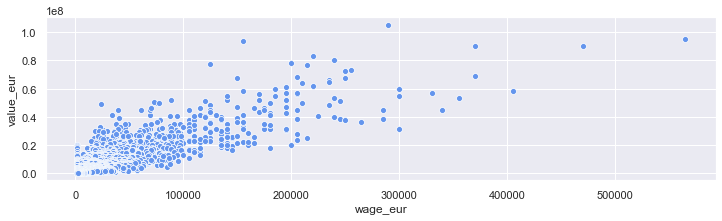

In [29]:
sns.scatterplot(data=df, x="wage_eur", y="value_eur", color="CornflowerBlue")

We see a strong correlation between wage and value. There seem to be small outliers. In rare cases players are underpaid, few more case there are players overpaid. A more thorough analysis here would be interesting

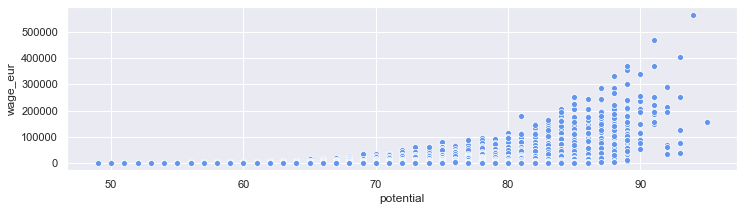

In [30]:
sns.scatterplot(data=df, x="potential", y="wage_eur", color="CornflowerBlue")

When we plot the potential against the wage, we see that there are quite a few "sleepers". These are players with very high potential (>85) which get quite a low wage. If clubs were to know the potential, these would be very interesting players.

In [31]:
len(df[(df.wage_eur < 3000) & (df.potential > 72)])

2010

Actually, there are over 2000 players with a potential greater than 72 and a wage of less than 3000. These are players which have a higher potential overall value than 75% of the players. In addition, they get paid less than half of the players.

### International Reputation

Description: (Not entirely sure) How well known and respected the player is on international scale

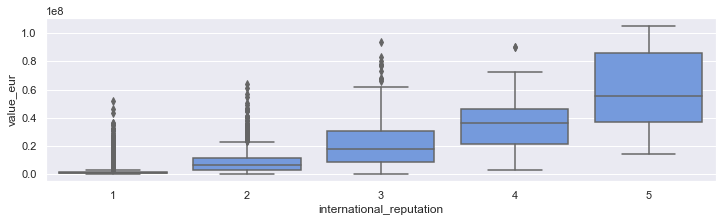

In [32]:
sns.boxplot(data=df, x="international_reputation", y="value_eur", color="CornflowerBlue")

In [33]:
df.international_reputation.value_counts()

1    16572
2     1118
3      286
4       46
5        6
Name: international_reputation, dtype: int64

As expected, the reputation affects the overall value

### Preferred foot / Weak foot

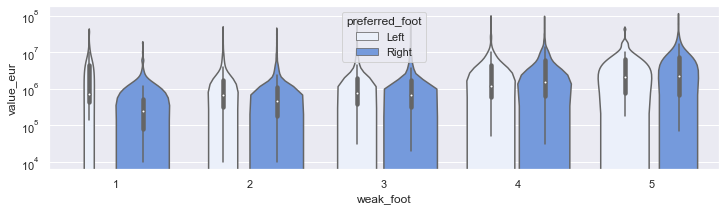

In [34]:
sns.violinplot(data=df, x="weak_foot", y="value_eur", color="CornflowerBlue", hue="preferred_foot")
plt.yscale("log")

Left footed players seem to have a higher value compared to right footed players, when the weak_foot skill is low. Both classes get more equal as weak_foot skill increases.

In [35]:
df.preferred_foot.value_counts()

Right    13770
Left      4258
Name: preferred_foot, dtype: int64

Left footed players are more rare (1:3). It would be interesting to see if this affects skills (dribbling, shooting) or positions.

In [36]:
# Encode column to use it in models later on
df.preferred_foot = df.preferred_foot.astype("category").cat.codes

### Skill moves

Description: The difficulty of the skill moves the player can execute

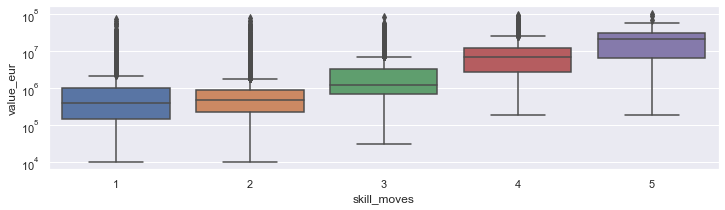

In [37]:
sns.boxplot(data=df, x="skill_moves", y="value_eur")
plt.yscale("log")

This feature is a bit dangerous to predict the value of a player. Intuitively higher skill moves leads to a higher median value. However, players with lower skill moves can be of ih value, too (e.g. Goalkeepers, Defenders). Also, there might be technically gifted players which are not worth much, because of other lacking skills.

### Team position

Description: Position of a player on its team. SUB: Player is on the bench. RES: Player is in reserve

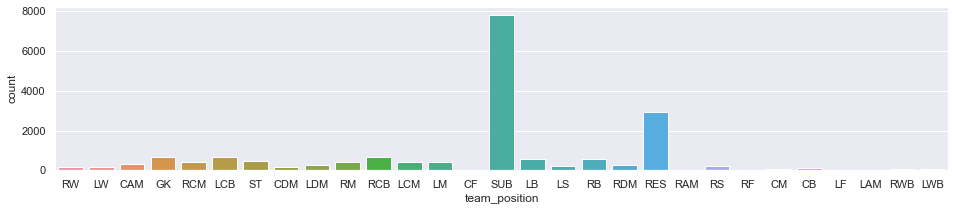

In [38]:
plt.figure(figsize=(16,3))
sns.countplot(data=df, x="team_position")

The biggest counts are sub and res, which is understandable because most teams have several players on the bench/in reserve. I would've expected the players to be listed on their original positions (e.g. A GK on the bench is listed as GK). Other than that, GK, LCB and RCB are the most common positions. This is due to that fact that every team has a GK and most teams play in a formation including RCB and LCB. Other positions, e.g. CF, are less common in the formations played by many teams.

### Player positions

In [39]:
# Splits and one hot encodes a column containing lists
mlb = MultiLabelBinarizer()

pos_df = pd.DataFrame(
    mlb.fit_transform(df.player_positions.str.replace(" ", "").str.split(",")),  # Convert String to List of positions and hot hot encoder them
    columns=[f"is_{pos}" for pos in mlb.classes_])  # Meaningful column names

pos_df.head()

,is_CAM,is_CB,is_CDM,is_CF,is_CM,is_GK,is_LB,is_LM,is_LW,is_LWB,is_RB,is_RM,is_RW,is_RWB,is_ST
0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1
1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
2,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0


In [40]:
df = df.reset_index(drop=True).join(pos_df)

In [41]:
df.head()

,short_name,long_name,age,height_cm,weight_kg,nationality,club,overall,potential,value_eur,...,is_GK,is_LB,is_LM,is_LW,is_LWB,is_RB,is_RM,is_RW,is_RWB,is_ST
0,L. Messi,Lionel Andrés Messi Cuccittini,32,170,72,Argentina,FC Barcelona,94,94,95500000,...,0,0,0,0,0,0,0,1,0,1
1,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,34,187,83,Portugal,Juventus,93,93,58500000,...,0,0,0,1,0,0,0,0,0,1
2,Neymar Jr,Neymar da Silva Santos Junior,27,175,68,Brazil,Paris Saint-Germain,92,92,105500000,...,0,0,0,1,0,0,0,0,0,0
3,J. Oblak,Jan Oblak,26,188,87,Slovenia,Atlético Madrid,91,93,77500000,...,1,0,0,0,0,0,0,0,0,0
4,E. Hazard,Eden Hazard,28,175,74,Belgium,Real Madrid,91,91,90000000,...,0,0,0,1,0,0,0,0,0,0


Now that we fixed the position issue, lets repeat the analysis done for team_position...

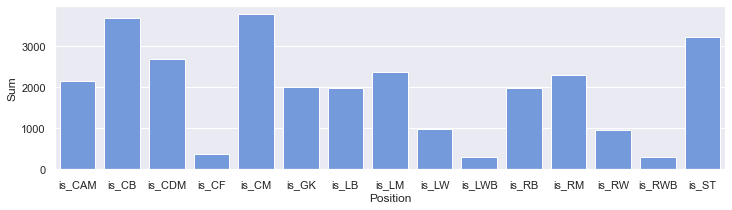

In [42]:
# Sum of one hot encoded positions
# Players are counted multiple times if capable of multiple positions
plot_df = (
    df.iloc[:, -15:]  # One Hot Position Encodings
    .sum()
    .to_frame()
    .reset_index()
    .rename({
        "index": "Position",
        0: "Sum"
    }, axis=1))

sns.barplot(data=plot_df, x="Position", y="Sum", color="CornflowerBlue")

This shows a more detailed picture of the distribution of positions. One sees that center back, center midfielder and striker are the most common positions. Other positions are very rare, i.e. CF, LWB and RWB. It would be interesting how this affects the price for players of the category.

To enable a less detailed view on the positions, we bucket them into "defender", "midfielder" and "striker". Goalkeepers, however, will remain in their own category.

In [43]:
pos_dict = {
    "defender": ["is_LB", "is_LWB", "is_CB", "is_RB", "is_RWB"],
    "midfielder": ["is_CAM", "is_CDM", "is_CM", "is_LM", "is_RM"],
    "striker": ["is_CF", "is_LW", "is_RW", "is_ST"]
}

for pos in pos_dict:
    df[f"is_{pos}"] = df[pos_dict[pos]].any(axis=1)

In [44]:
df[["is_GK", "is_defender", "is_midfielder", "is_striker"]].sum()

is_GK            1996.0
is_defender      6521.0
is_midfielder    8503.0
is_striker       4435.0
dtype: float64

We see midfielder is the most common position. I would argue this is due to the fact that many strikers and defenders can play hybrid roles (e.g. CDM, CAM, wing midfielders). For the moment I omit a more thorough exploration.

## Skill analysis

In [45]:
skill_list = list(df.columns[28:-18])

It would be interesting to identify the most important skills per position group that affect the overall value of the player. Lets start with defenders

### Defenders

In [46]:
df_def = df[df.is_defender]
df_def.describe()

,age,height_cm,weight_kg,overall,potential,value_eur,wage_eur,preferred_foot,international_reputation,weak_foot,...,is_GK,is_LB,is_LM,is_LW,is_LWB,is_RB,is_RM,is_RW,is_RWB,is_ST
count,6521.000000,6521.000000,6521.000000,6521.000000,6521.000000,6.521000e+03,6521.000000,6521.000000,6521.000000,6521.000000,...,6521.0,6521.000000,6521.000000,6521.000000,6521.000000,6521.000000,6521.000000,6521.000000,6521.000000,6521.000000
mean,25.541328,182.494403,76.234473,66.225272,71.159178,2.121001e+06,8886.213771,0.676123,1.086030,2.834841,...,0.0,0.303788,0.072228,0.008741,0.047692,0.303481,0.065481,0.006134,0.045085,0.005521
std,4.496575,6.218220,6.531337,6.524871,5.878352,4.412836e+06,17951.560464,0.467989,0.337516,0.609878,...,0.0,0.459927,0.258885,0.093091,0.213130,0.459796,0.247391,0.078085,0.207507,0.074101
min,16.000000,162.000000,50.000000,48.000000,49.000000,1.000000e+04,1000.000000,0.000000,1.000000,1.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.000000,178.000000,72.000000,62.000000,67.000000,3.250000e+05,1000.000000,0.000000,1.000000,2.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,25.000000,183.000000,76.000000,66.000000,71.000000,6.750000e+05,3000.000000,1.000000,1.000000,3.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,29.000000,187.000000,80.000000,70.000000,75.000000,1.800000e+06,8000.000000,1.000000,1.000000,3.000000,...,0.0,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,39.000000,203.000000,101.000000,90.000000,93.000000,7.800000e+07,300000.000000,1.000000,4.000000,5.000000,...,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


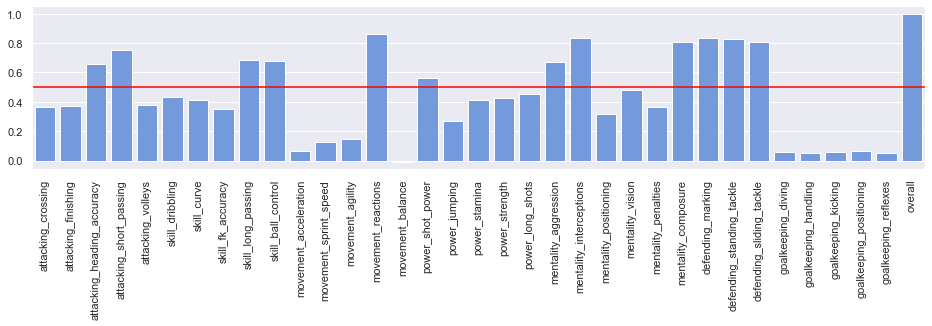

In [47]:
plt.figure(figsize=(16,3))
sns.barplot(data=df_def[skill_list + ["overall"]].corr().overall.to_frame().transpose(), color="CornflowerBlue")
plt.xticks(rotation=90)
plt.axhline(0.5, color="red")
plt.show()

With a look at the correlation of skills to the overall skill of the players, we can identify key skills for defenders. Intuitively, defending skills are most important for defenders. However, interceptions, aggression as well as reactions are correlated equally high. Given the role of a defender, this is reasonable.

More interesting are the offensive skills, that seem important for defenders. We can see that long and short passing as well as header power are important. Given that modern defenders are heavily involved in creating attacks, this seems reasonable. 

It surprises me that jumping, strength and positioning are rather low correlated. Lets look at this for different position groups in the defenders

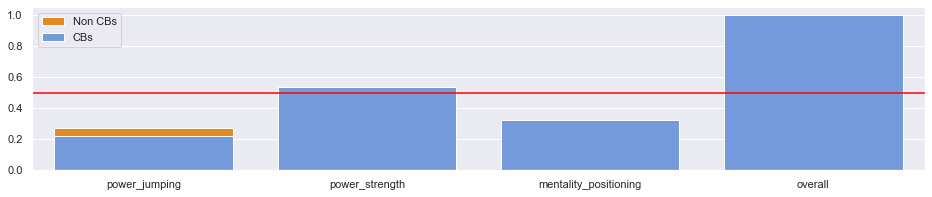

In [48]:
pos_mask = (df_def.is_CB == 1)
skill_list_slice = ["power_jumping", "power_strength", "mentality_positioning"]

plt.figure(figsize=(16,3))
sns.barplot(data=df_def[skill_list_slice + ["overall"]].corr().overall.to_frame().transpose(), color="DarkOrange", label="Non CBs")
sns.barplot(data=df_def[skill_list_slice + ["overall"]][pos_mask].corr().overall.to_frame().transpose(), color="CornflowerBlue", label="CBs")
# plt.xticks(rotation=90)
plt.legend()
plt.axhline(0.5, color="red")
plt.show()

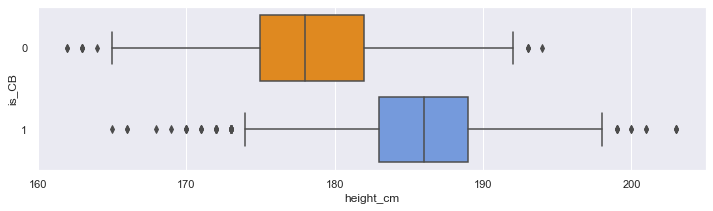

In [49]:
sns.boxplot(data=df_def, y="is_CB", x="height_cm", orient="h", palette=["DarkOrange", "CornflowerBlue"])

When we compare center backs against full backs, we see that jumping is less important for CBs while positioning and strength is more important. A comparisson of the height distributions between CBs and other defenders make obvious why jumping is less important for CBs. The increase in strength and positioning is reasonable

### Midfielders

In [50]:
df_mid = df[df.is_midfielder]

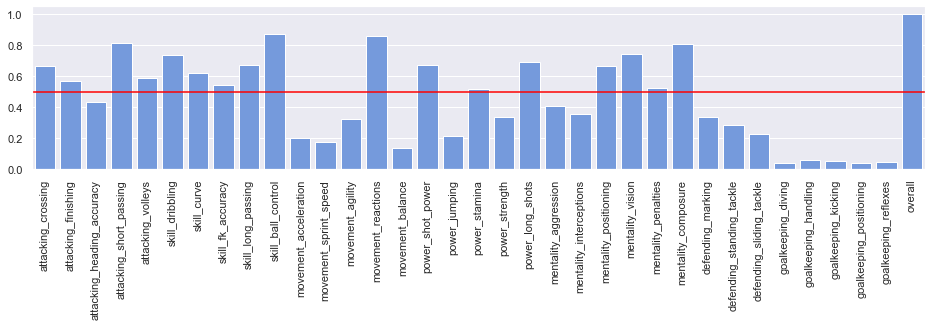

In [51]:
plt.figure(figsize=(16,3))
sns.barplot(data=df_mid[skill_list + ["overall"]].corr().overall.to_frame().transpose(), color="CornflowerBlue")
plt.xticks(rotation=90)
plt.axhline(0.5, color="red")
plt.show()

### Strikers

In [52]:
df_str = df[df.is_striker]

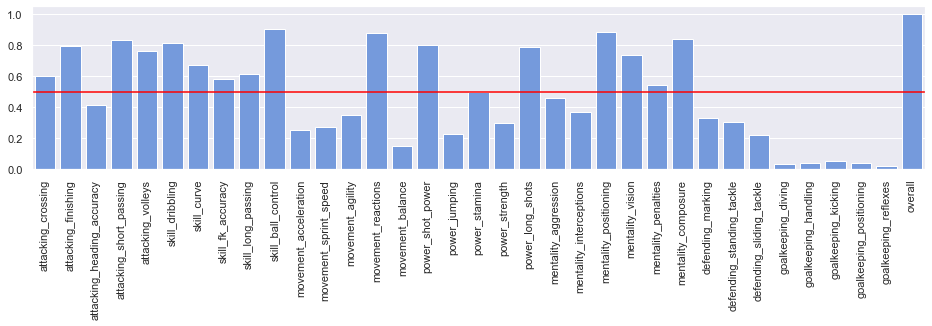

In [53]:
plt.figure(figsize=(16,3))
sns.barplot(data=df_str[skill_list + ["overall"]].corr().overall.to_frame().transpose(), color="CornflowerBlue")
plt.xticks(rotation=90)
plt.axhline(0.5, color="red")
plt.show()

## Question: Do left footed players differ from right footed ones w.r.t. skills / positions

### Hypothesis: Left footed players are better dribblers

Lets look at different scenarios in which this hypothesis could be true, i.e.:

1. This is true over the whole data set
2. This is true for players with a overall value < 80
3. This is true for midfielders only, since they are heavily involved in dribbling
4. This is true for a combination of 2 and 3

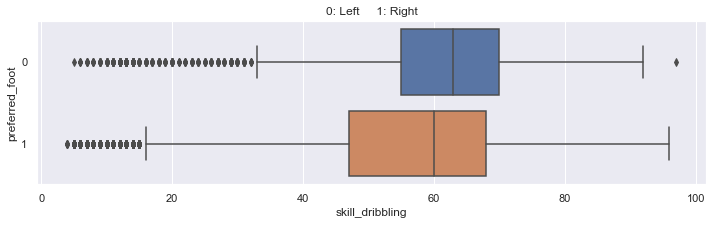

MannwhitneyuResult(statistic=24784761.0, pvalue=5.804703564891679e-53)


In [54]:
sns.boxplot(data=df, y="preferred_foot", x="skill_dribbling", orient="h")
plt.title("0: Left     1: Right")
plt.show()

print(mannwhitneyu(
    df[df.preferred_foot == 0].skill_dribbling.to_numpy(),
    df[df.preferred_foot == 1].skill_dribbling.to_numpy(),
))

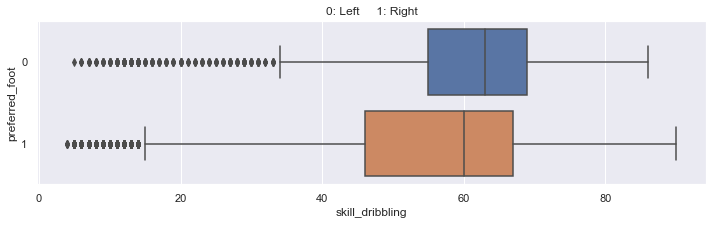

MannwhitneyuResult(statistic=23162645.0, pvalue=1.524736386097251e-53)


In [55]:
sns.boxplot(data=df[df.overall < 80], y="preferred_foot", x="skill_dribbling", orient="h")
plt.title("0: Left     1: Right")
plt.show()

print(mannwhitneyu(
    df[(df.preferred_foot == 0) & (df.overall < 80)].skill_dribbling.to_numpy(),
    df[(df.preferred_foot == 1) & (df.overall < 80)].skill_dribbling.to_numpy(),
))

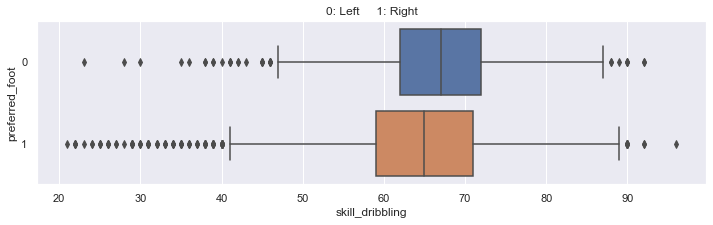

MannwhitneyuResult(statistic=5628654.0, pvalue=2.8222170403538157e-21)


In [56]:
sns.boxplot(data=df[df.is_midfielder], y="preferred_foot", x="skill_dribbling", orient="h")
plt.title("0: Left     1: Right")
plt.show()

print(mannwhitneyu(
    df[(df.preferred_foot == 0) & (df.is_midfielder)].skill_dribbling.to_numpy(),
    df[(df.preferred_foot == 1) & (df.is_midfielder)].skill_dribbling.to_numpy(),
))

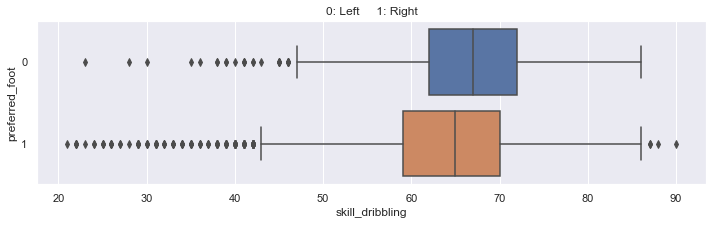

MannwhitneyuResult(statistic=5256777.0, pvalue=2.9230319706809916e-22)


In [57]:
sns.boxplot(data=df[(df.is_midfielder) & (df.overall < 80)], y="preferred_foot", x="skill_dribbling", orient="h")
plt.title("0: Left     1: Right")
plt.show()

print(mannwhitneyu(
    df[(df.preferred_foot == 0) & (df.overall < 80) & (df.is_midfielder)].skill_dribbling.to_numpy(),
    df[(df.preferred_foot == 1) & (df.overall < 80) & (df.is_midfielder)].skill_dribbling.to_numpy(),
))

With the p-value being so close to 0 for every of the cases (Rule of thumb: If p < 0.05 we can reject the null hypothesis) we can assume that the two distributions are in fact different. This results in the answer to the question: Left-footed players seem to be more skilled at dribbling than right footed ones 

### Hypothesis: The preferred foot affects the position of a player

I expect that players which play a role in the offensive game plan play on the opposite side of their preferred foot. This way they can cut into the middle of the field and shoot from there (looking at you, Arjen Robben)

In [58]:
left_positions_mask = (
    (df.is_LW) |
    (df.is_LWB) |
    (df.is_LB) |
    (df.is_LM)
).astype(bool)

left_positions_without_lb_mask = (
    (df.is_LW) |
    (df.is_LWB) |
    (df.is_LM)
).astype(bool)

right_positions_mask = (
    (df.is_RW) |
    (df.is_RWB) |
    (df.is_RB) |
    (df.is_RM)
).astype(bool)

right_positions_without_rb_mask = (
    (df.is_RW) |
    (df.is_RWB) |
    (df.is_RM)
).astype(bool)

Note that this is not completely accurate since some players can play both on the left and right side. We will neglect this for now.

In [59]:
print(f"Overall foot distribution: {100*df.preferred_foot.sum() / len(df):.2f}% right footed")

Overall foot distribution: 76.38% right footed


Foot distributions with LB: 50.37% right footed
Foot distributions without LB: 59.57% right footed


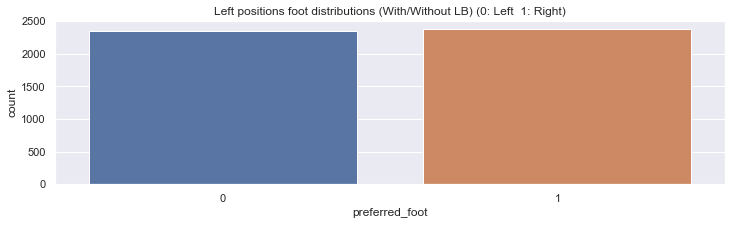

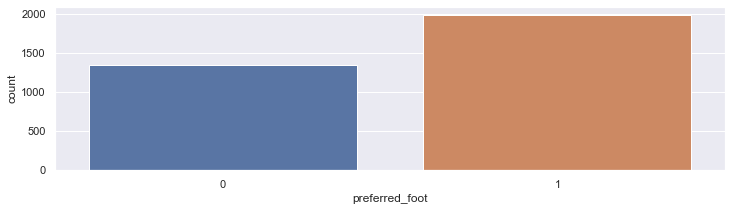

In [60]:
plt.title("Left positions foot distributions (With/Without LB) (0: Left  1: Right)")
sns.countplot(df[left_positions_mask].preferred_foot)

plt.figure()
sns.countplot(df[left_positions_without_lb_mask].preferred_foot)

print(f"Foot distributions with LB: {100*df[left_positions_mask].preferred_foot.sum() / len(df[left_positions_mask]):.2f}% right footed")
print(f"Foot distributions without LB: {100*df[left_positions_without_lb_mask].preferred_foot.sum() / len(df[left_positions_without_lb_mask]):.2f}% right footed")

Foot distributions with RB: 84.16% right footed
Foot distributions without RB: 78.28% right footed


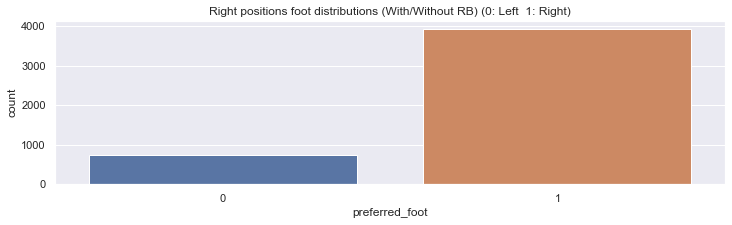

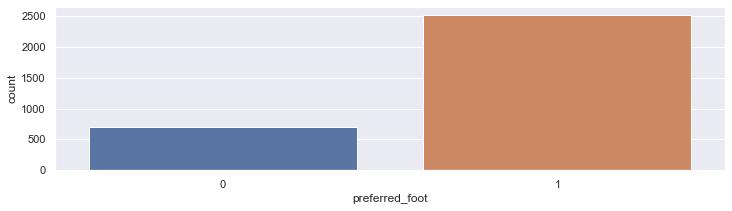

In [61]:
plt.title("Right positions foot distributions (With/Without RB) (0: Left  1: Right)")
sns.countplot(df[right_positions_mask].preferred_foot)

plt.figure()
sns.countplot(df[right_positions_without_rb_mask].preferred_foot)


print(f"Foot distributions with RB: {100*df[right_positions_mask].preferred_foot.sum() / len(df[right_positions_mask]):.2f}% right footed")
print(f"Foot distributions without RB: {100*df[right_positions_without_rb_mask].preferred_foot.sum() / len(df[right_positions_without_rb_mask]):.2f}% right footed")

When we compare the numbers, it becomes clear that the opposite of our hypothesis is true: Players rather play on the side of their preferred foot. We looked at left and right backs separately. While these have an effect (they seem to be mostly right footed, which fits the overall trend of players) our original hypothesis is still wrong if we leave RB and LB out of the analysis.

## Finish

In [62]:
df.to_csv(os.path.join("..", "data", "post_eda_data.csv"), index=False)